In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import util_tr_new as tr
import os

import numpy as np
from scipy import interpolate, signal
import pandas as pd
import os.path
import os
import sys
import matplotlib.pyplot as plt


# ################################  Library  ########################################
def split_up_down(x_raw, y_raw):
    size = len(x_raw)
    is_sweep_up_down = False if x_raw[0] > x_raw[size // 4] else True
    # print("up to down" if(is_sweep_up_down) else "down to up")
    if is_sweep_up_down:
        return_index = np.argmax(x_raw)
        x_raw_u = x_raw[:return_index + 1]
        x_raw_d = x_raw[return_index:]
        y_raw_u = y_raw[:return_index + 1]
        y_raw_d = y_raw[return_index:]
    else:
        return_index = np.argmin(x_raw)
        x_raw_d = x_raw[:return_index + 1]
        x_raw_u = x_raw[return_index:]
        y_raw_d = y_raw[:return_index + 1]
        y_raw_u = y_raw[return_index:]
    return (x_raw_u, y_raw_u, x_raw_d, y_raw_d)


def common_part(x, y):
    # 1D-arrayXとYの範囲の共通部分に属する要素のみを残す
    # 共通部分の最大値＝それぞれのarrayの最大値の中で最小のもの
    max_value = np.min([np.max(x), np.max(y)])
    min_value = np.max([np.min(x), np.min(y)])
    concat_array = np.concatenate([x, y])
    common_array = sorted(set([
        x for x in concat_array if x <= max_value and x >= min_value
    ]))
    return common_array


def symmetrize(x_raw_u, y_raw_u, x_raw_d=None, y_raw_d=None):
    """
    データを折り返し対称にする
    x_raw_u: x_raw of up sweep
    y_raw_u: y_raw of up sweep
    x_raw_d: x_raw of down sweep
    y_raw_d: y_raw of down sweep

    """
    if x_raw_d is None and y_raw_d is None: # もしdown sweepがないなら
        y_int = interpolate.interp1d(x_raw_u, y_raw_u)
        x_ref = np.array(
            [x for x in x_raw_u if x <= np.max(x_raw_u * -1) and x >= np.min(x_raw_u * -1)]
        )
        y_sym = (y_int(x_ref) + y_int(-1 * x_ref)) / 2
        y_asym = (y_int(x_ref) - y_int(-1 * x_ref)) / 2
        return (x_ref, y_sym, y_asym)
    else: # もしdown sweepがあるなら
        y_int_u = interpolate.interp1d(x_raw_u, y_raw_u)
        y_int_d = interpolate.interp1d(x_raw_d, y_raw_d)
        x_ref_u = common_part(x_raw_d, x_raw_u)
        x_ref_d = x_ref_u[::-1]
        y_sym_d = (y_int_d(x_ref_d) + y_int_u(x_ref_u)) / 2
        y_asym_d = (y_int_d(x_ref_d) - y_int_u(x_ref_u)) / 2
        # y_sym_u = y_sym_d[::-1]
        y_sym_u = y_sym_d
        # y_asym_u = y_asym_d[::-1]
        y_asym_u = y_asym_d * -1
        return (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)


def diff_up_down_sweep(B_u, R_u, B_d, R_d):
    R_u_int = interpolate.interp1d(B_u, R_u)
    R_d_int = interpolate.interp1d(B_d, R_d)
    B_ref = common_part(B_d, B_u)
    R_diff = R_u_int(B_ref) - R_d_int(B_ref)
    R_diff_abs = [(R_u_int(x) - R_d_int(x)) if x > 0 else (R_d_int(x) - R_u_int(x)) for x in B_ref]
    return B_ref, R_diff, R_diff_abs


def smooth_data(x_raw, convolve_size=41):
    # smooth
    convolve_array = np.ones(convolve_size) / convolve_size
    x_raw_convolve = np.convolve(x_raw, convolve_array, mode="valid")
    return x_raw_convolve


def analyze_Hall(B_raw, Rxx_raw, Ryx_raw, fixed_temp=0, thickness=0):
    # 温度固定、磁場スイープ
    # 折返し有り無し判定(磁性体か非磁性か)
    is_up_down = True if B_raw[0] * B_raw[len(B_raw) - 1] > 0 else False
    if is_up_down:
        # 往復あり(磁性体)
        B_ref_u, Rxx_u, _, B_ref_d, Rxx_d, _ = symmetrize(*split_up_down(B_raw, Rxx_raw))
        B_ref_u, _, Ryx_u, B_ref_d, _, Ryx_d = symmetrize(*split_up_down(B_raw, Ryx_raw))
        Gxx_d = Rxx_d / (Rxx_d**2 + Ryx_d**2)
        Gxy_d = Ryx_d / (Rxx_d**2 + Ryx_d**2)
        Gxx_u = Rxx_u / (Rxx_u**2 + Ryx_u**2)
        Gxy_u = Ryx_u / (Rxx_u**2 + Ryx_u**2)
        Rxx_d_int = interpolate.interp1d(B_ref_d, Rxx_d)
        Ryx_d_int = interpolate.interp1d(B_ref_d, Ryx_d)
        Ryx_u_int = interpolate.interp1d(B_ref_u, Ryx_u)
        Ryx_d_sq = Ryx_d**2
        B_over_Ryx = B_ref_d / Ryx_d
        temp = np.full_like(B_ref_u, fixed_temp)
        RyxA = (Ryx_d_int(0) - Ryx_u_int(0)) / 2
        Rxx0 = Rxx_d_int(0)
        HallAngle_d = Ryx_d / Rxx_d
        HallAngle_u = Ryx_u / Rxx_u
        HallAngle0 = RyxA / Rxx0
        # down scanのB>0だけ取り出してフィッティングする
        subdf_d_pos = pd.DataFrame(np.array([B_raw, Ryx_raw]).T, columns=["B", "Ryx"]).query("B > 0")
        B_ref_d_pos = subdf_d_pos["B"].values
        Ryx_d_pos = subdf_d_pos["Ryx"].values
        fit = np.polyfit(B_ref_d_pos, Ryx_d_pos, 1)
        carrier2D = 1e-4 / (1.602e-19 * fit[0])
        mobility = 1e4 * fit[0] / Rxx0
        if thickness == 0:
            # 2D
            data = np.array([temp, B_ref_d, B_ref_u, Rxx_d, Rxx_u, Ryx_d, Ryx_u, Gxx_d, Gxx_u, Gxy_d, Gxy_u, Ryx_d_sq, B_over_Ryx, HallAngle_d, HallAngle_u])
            columns = ["temp", "B_ref_d", "B_ref_u", "Rxx_d", "Rxx_u", "Ryx_d", "Ryx_u", "Gxx_d", "Gxx_u", "Gxy_d", "Gxy_u", "Ryx_d_sq", "B_over_Ryx", "HallAngle_d", "HallAngle_u"]
            series_summary = pd.Series([fixed_temp, Rxx0, RyxA, RyxA, carrier2D, mobility, np.abs(carrier2D), np.abs(mobility), HallAngle0], index=["temps", "Rxx0T", "RyxA", "RyxA_norm", "carrier2D", "mobility", "carrier2D_abs", "mobility_abs", "HallAngle0"])
        else:
            # 3D
            Rxx_u_3D = Rxx_u * thickness * 1e2
            Rxx_d_3D = Rxx_d * thickness * 1e2
            Ryx_u_3D = Ryx_u * thickness * 1e2
            Ryx_d_3D = Ryx_d * thickness * 1e2
            Gxx_d_3D = Gxx_d / (thickness * 1e2)
            Gxy_d_3D = Gxy_d / (thickness * 1e2)
            Gxx_u_3D = Gxx_u / (thickness * 1e2)
            Gxy_u_3D = Gxy_u / (thickness * 1e2)
            RyxA_3D = RyxA * thickness * 1e2
            Rxx0_3D = Rxx0 * thickness * 1e2
            carrier3D = carrier2D / (thickness * 1e2)
            data = np.array([temp, B_ref_d, B_ref_u, Rxx_d, Rxx_u, Ryx_d, Ryx_u, Gxx_d, Gxx_u, Gxy_d, Gxy_u, Ryx_d_sq, B_over_Ryx, HallAngle_d, HallAngle_u, Rxx_u_3D, Rxx_d_3D, Ryx_u_3D, Ryx_d_3D, Gxx_u_3D, Gxx_d_3D, Gxy_u_3D, Gxy_d_3D])
            columns = ["temp", "B_ref_d", "B_ref_u", "Rxx_d", "Rxx_u", "Ryx_d", "Ryx_u", "Gxx_d", "Gxx_u", "Gxy_d", "Gxy_u", "Ryx_d_sq", "B_over_Ryx", "HallAngle_d", "HallAngle_u", "Rxx_u_3D", "Rxx_d_3D", "Ryx_u_3D", "Ryx_d_3D", "Gxx_u_3D", "Gxx_d_3D", "Gxy_u_3D", "Gxy_d_3D"]
            series_summary = pd.Series([fixed_temp, Rxx0, RyxA, RyxA, carrier2D, mobility, np.abs(carrier2D), np.abs(mobility), HallAngle0, Rxx0_3D, RyxA_3D, carrier3D, np.abs(carrier3D)], index=["temps", "Rxx0T", "RyxA", "RyxA_norm", "carrier2D", "mobility", "carrier2D_abs", "mobility_abs", "HallAngle0", "Rxx0T_3D", "RyxA_3D", "carrier3D", "carrier3D_abs"])
    else:
        # 往復なし(非磁性体)
        B_ref, Rxx, _ = symmetrize(B_raw, Rxx_raw)
        B_ref, _, Ryx = symmetrize(B_raw, Ryx_raw)
        Gxx = Rxx / (Rxx**2 + Ryx**2)
        Gxy = Ryx / (Rxx**2 + Ryx**2)
        Rxx_int = interpolate.interp1d(B_ref, Rxx)
        # Ryx_int = interpolate.interp1d(B_ref, Ryx)
        temp = np.full_like(B_ref, fixed_temp)
        Rxx0 = Rxx_int(0)
        # Ryx0 = Ryx_int(0)
        HallAngle = Ryx / Rxx
        try:
            fit = np.polyfit(B_ref, Ryx, 1)
        except BaseException:
            print(str(fixed_temp) + "K")
            import traceback
            traceback.print_exc()
        carrier2D = 1e-4 / (1.602e-19 * fit[0])
        mobility = 1e4 * fit[0] / Rxx0
        if thickness == 0:
            # 2D
            data = np.array([temp, B_ref, Rxx, Ryx, Gxx, Gxy, HallAngle, np.abs(HallAngle)])
            columns = ["temp", "B_ref", "Rxx", "Ryx", "Gxx", "Gxy", "HallAngle", "HallAngle_abs"]
            series_summary = pd.Series([fixed_temp, carrier2D, mobility, np.abs(carrier2D), np.abs(mobility)], index=["temps", "carrier2D", "mobility", "carrier2D_abs", "mobility_abs"])
        else:
            # 3D
            Rxx_3D = Rxx * thickness * 1e2
            Ryx_3D = Ryx * thickness * 1e2
            Gxx_3D = Gxx / (thickness * 1e2)
            Gxy_3D = Gxy / (thickness * 1e2)
            Rxx0_3D = Rxx0 * thickness * 1e2
            carrier3D = carrier2D / (thickness * 1e2)
            data = np.array([temp, B_ref, Rxx, Ryx, Gxx, Gxy, HallAngle, np.abs(HallAngle), Rxx_3D, Ryx_3D, Gxx_3D, Gxy_3D])
            columns = ["temp", "B_ref", "Rxx", "Ryx", "Gxx", "Gxy", "HallAngle", "HallAngle_abs", "Rxx_3D", "Ryx_3D", "Gxx_3D", "Gxy_3D"]
            series_summary = pd.Series([fixed_temp, carrier2D, mobility, np.abs(carrier2D), np.abs(mobility), carrier3D, np.abs(carrier3D)], index=["temps", "carrier2D", "mobility", "carrier2D_abs", "mobility_abs", "carrier3D", "carrier3D_abs"])
    df = pd.DataFrame(data=data.T, columns=columns)
    return (df, series_summary)


def analyze_Hall_multi_temps(temp, B, Rxx, Ryx, I_Rxx=None, I_Ryx=None, thickness=0, temp_threshold=0.1):
    if I_Rxx is None or I_Ryx is None:
        df = pd.DataFrame(np.array([temp, B, Rxx, Ryx]).T, columns=["temp", "B", "Rxx", "Ryx"])
    else:
        exists_I = True
        df = pd.DataFrame(np.array([temp, B, Rxx, Ryx, I_Rxx, I_Ryx]).T, columns=["temp", "B", "Rxx", "Ryx", "I_Rxx", "I_Ryx"])

    # 各温度ごとのデータをまとめるための準備(df_summary, dic, dic_raw)
    df_summary = pd.DataFrame()  # 各温度点の特徴量をまとめたデータ(indexは温度点)
    dic = {}  # 各温度における解析済みデータ
    dic_raw = {}  # 各温度点における生データ

    # 各温度点で解析
    # 温度のdiffを取る
    df["temp_diff"] = df["temp"].diff()
    # diffがしきい値を超えたところでgroupbyする。
    # (df["temp_diff"] > temp_threshold)という列に対してcumsum(要素の足し合わせ)を実行
    for _, df_raw in df.groupby((df["temp_diff"] > temp_threshold).cumsum()):
        # 平均温度を計算
        fixed_temp = round(df_raw["temp"].mean(), 1)
        # 各温度で生データ取得
        # temp_raw = df_raw["temp"].values
        B_raw = df_raw["B"].values
        Rxx_raw = df_raw["Rxx"].values
        Ryx_raw = df_raw["Ryx"].values
        df_raw = df_raw.drop("temp_diff", axis=1)
        # Hall解析
        df, series_summary = analyze_Hall(B_raw, Rxx_raw, Ryx_raw, fixed_temp, thickness)
        # 温度点の解析結果をdicに追加
        dic[str(fixed_temp)] = df
        dic_raw[str(fixed_temp)] = df_raw
        if exists_I is True:
            # summaryにExcitation current追加
            series_summary["I_Rxx"] = df_raw["I_Rxx"].mean()
            series_summary["I_Ryx"] = df_raw["I_Ryx"].mean()
            # df_rawの列名変更
            df_raw.columns = ["temp_raw", "B_raw", "Rxx_raw", "Ryx_raw", "I_Rxx", "I_Ryx"]
        else:
            # df_rawの列名変更
            df_raw.columns = ["temp_raw", "B_raw", "Rxx_raw", "Ryx_raw"]
        # summaryデータのdfを更新
        df_summary = df_summary.append(series_summary, ignore_index=True)
    # summaryデータの処理
    # すべてがNaNな行、列を削除
    df_summary = df_summary.dropna(how='all').dropna(how='all', axis=1)
    # RyxA_normの規格化
    if "RyxA_norm" in df_summary.columns:
        df_summary["RyxA_norm"] = df_summary["RyxA_norm"].map(lambda x: x / df_summary["RyxA_norm"][0])
    return dic, dic_raw, df_summary


def save_Hall_multi_temps(savepath, dic, dic_raw, df_summary):
    # 対称化データ(Hall)
    if dic is not None:
        for temp, df in dic.items():
            df.to_csv(os.path.join(savepath, "Hall_" + str(temp) + "K.csv"), index=False)
    # 対称化していない生データ(raw)
    if dic_raw is not None:
        for temp, df_raw in dic_raw.items():
            df_raw.to_csv(os.path.join(savepath, "raw_" + str(temp) + "K.csv"), index=False)
    # summaryデータ:temp_dep
    if df_summary is not None:
        df_summary.to_csv(os.path.join(savepath, "temp_dep.csv"), index=False)
    return


def analyze_and_plot_Hall_data(savepath, sample_str, temp, B, Rxx, Ryx, I_Rxx=None, I_Ryx=None, thickness=0, temp_threshold=0.1):
    # 各温度点の解析
    dic, dic_raw, df_summary = analyze_Hall_multi_temps(temp, B, Rxx, Ryx, I_Rxx, I_Ryx, thickness, temp_threshold)
    # ファイル保存
    save_Hall_multi_temps(savepath, dic, dic_raw, df_summary)

    # グラフ描画(解析データ)
    fig = plot_B_dep_data(dic, dic_raw, sample_str)
    # グラフ保存(解析データ)
    fig.savefig(os.path.join(savepath, "B-dep.png"))

    # グラフ描画(summaryデータ)
    fig = plot_summary_data(df_summary, sample_str)
    # グラフ保存(summaryデータ)
    fig.savefig(os.path.join(savepath, "summary.png"))
    return


# ###################### plot ###########################
def plot_B_dep_data(dic, dic_raw, sample_str=""):
    # グラフ描画準備
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.subplots_adjust(wspace=0.5, hspace=0.2)
    fig.text(0.1, 0.9, sample_str)

    for temp, df in dic_raw.items():
        # プロット:raw
        ax[0][1].plot(df["B_raw"], df["Rxx_raw"])
        ax[1][1].plot(df["B_raw"], df["Ryx_raw"])
        ax[0][1].set_ylabel("Rxx_raw (Ohm)")
        ax[1][1].set_ylabel("Ryx_raw (Ohm)")
        ax[1][1].set_xlabel("B (T)")

        ax[0][2].plot(df["B_raw"], df["I_Rxx"])
        ax[1][2].plot(df["B_raw"], df["I_Ryx"])
        ax[0][2].set_ylabel("I_Rxx (A)")
        ax[1][2].set_ylabel("I_Ryx (A)")
        ax[1][2].set_xlabel("B (T)")

    for temp, df in dic.items():
        # プロット:解析データ
        if "B_ref_d" in df.columns:
            # AHE
            ax[0][0].plot(pd.concat([df["B_ref_d"], df["B_ref_u"]]), pd.concat([df["Rxx_d"], df["Rxx_u"]]))
            ax[1][0].plot(pd.concat([df["B_ref_d"], df["B_ref_u"]]), pd.concat([df["Ryx_d"], df["Ryx_u"]]))
        else:
            # OHE
            ax[0][0].plot(df["B_ref"], df["Rxx"])
            ax[1][0].plot(df["B_ref"], df["Ryx"])
        ax[0][0].set_ylabel("Rxx (Ohm)")
        ax[1][0].set_ylabel("Ryx (Ohm)")
        ax[1][0].set_xlabel("B (T)")
    return fig


def plot_summary_data(df_summary, sample_str=""):
    # グラフ描画準備
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(3, 9))
    plt.subplots_adjust(wspace=0.2, hspace=0.2, left=0.3)
    fig.text(0.1, 0.9, sample_str)
    # プロット:temp-dep
    ax[0].plot(df_summary["temps"], df_summary["carrier2D_abs"], marker="o", color="red")
    ax[0].set_ylabel("carrier 2D(cm-2)")
    if "carrier3D_abs" in df_summary.columns:
        ax[1].plot(df_summary["temps"], df_summary["carrier3D_abs"], marker="o", color="red")
        ax[1].set_ylabel("carrier 3D(cm-3)")
    if "RyxA" in df_summary.columns:
        ax[2].plot(df_summary["temps"], df_summary["RyxA"], marker="o", color="red")
        ax[2].set_ylabel("RyxA (Ohm)")
    else:
        ax[2].plot(df_summary["temps"], df_summary["mobility"], marker="o", color="red")
        ax[2].set_ylabel("mobility (cm2V-1s-1)")
    ax[2].set_xlabel("T (K)")
    return fig


def plot_RT_data(df_RT, sample_str=""):
    if "Rxx_3D" in df_RT.columns:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(6, 9))
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
        fig.text(0.1, 0.9, sample_str)
        ax[0][0].plot(df_RT["temp"], df_RT["Rxx"], color="red")
        ax[0][1].plot(df_RT["temp"], df_RT["Ryx"], color="red")
        ax[0][0].set_ylabel("Rxx_2D (Ohm)")
        ax[0][1].set_ylabel("Ryx_2D (Ohm)")
        ax[1][0].plot(df_RT["temp"], df_RT["Rxx_3D"], color="red")
        ax[1][1].plot(df_RT["temp"], df_RT["Ryx_3D"], color="red")
        ax[1][0].set_ylabel("Rxx_3D (Ohm cm)")
        ax[1][1].set_ylabel("Ryx_3D (Ohm cm)")
        ax[2][0].plot(df_RT["temp"], df_RT["I_Rxx"], color="red")
        ax[2][1].plot(df_RT["temp"], df_RT["I_Ryx"], color="red")
        ax[2][0].set_ylabel("I_Rxx (A)")
        ax[2][1].set_ylabel("I_Ryx (A)")
        ax[2][0].set_xlabel("T (K)")
        ax[2][1].set_xlabel("T (K)")
    else:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
        plt.subplots_adjust(wspace=0.5, hspace=0.2)
        fig.text(0.1, 0.9, sample_str)
        ax[0][0].plot(df_RT["temp"], df_RT["Rxx"], color="red")
        ax[0][1].plot(df_RT["temp"], df_RT["Ryx"], color="red")
        ax[0][0].set_ylabel("Rxx_2D (Ohm)")
        ax[0][1].set_ylabel("Ryx_2D (Ohm)")
        ax[1][0].plot(df_RT["temp"], df_RT["I_Rxx"], color="red")
        ax[1][1].plot(df_RT["temp"], df_RT["I_Ryx"], color="red")
        ax[1][0].set_ylabel("I_Rxx (A)")
        ax[1][1].set_ylabel("I_Ryx (A)")
        ax[1][0].set_xlabel("T (K)")
        ax[1][1].set_xlabel("T (K)")
    return fig

###########################

def make_savepath(filepath, savedir=""):
    # 保存ファイルパスを決定
    filedir = os.path.dirname(filepath)
    filebasename = os.path.basename(filepath)
    filename, fileext = os.path.splitext(filebasename)
    if savedir == "":
        savepath = filedir
    else:
        savepath = os.path.join(filedir, savedir)
        if os.path.isdir(savepath) is False:
            print("makedirs : " + savepath)
            os.makedirs(savepath)
    return filename, fileext, savepath


def get_data_columns_from_ppms_file(filepath, ch_num):
    # ファイル取得 dat, ch_numに対応する列を取得
    df = pd.read_csv(filepath, skiprows=range(0, 31))
    B = df["Magnetic Field (Oe)"] * 1e-4
    temp = df["Temperature (K)"]
    Rxx = df["Bridge " + str(ch_num[0]) + " Resistivity (Ohm-cm)"]
    Ryx = df["Bridge " + str(ch_num[1]) + " Resistivity (Ohm-cm)"]
    I_Rxx = df["Bridge " + str(ch_num[0]) + " Excitation (uA)"] * 1e-6
    I_Ryx = df["Bridge " + str(ch_num[1]) + " Excitation (uA)"] * 1e-6
    return B, temp, Rxx, Ryx, I_Rxx, I_Ryx


def analyze_Hall_multi_temps_ppms(filepath, ch_num, sample_str, thickness=0, temp_threshold=0.1):
    """_summary_

    Args:
        filepath (_type_): 
        ch_num (_type_): _description_
        sample_str (_type_): _description_
        thickness (int, optional): _description_. Defaults to 0.
        temp_threshold (float, optional): _description_. Defaults to 0.1.
    """
    # 保存ファイルパスを決定
    filename, fileext, savepath = make_savepath(filepath, savedir=sample_str)
    print("savepath", savepath)
    # ファイル取得 dat, ch_numに対応する列を取得
    B, temp, Rxx, Ryx, I_Rxx, I_Ryx = get_data_columns_from_ppms_file(filepath, ch_num)
    # 解析・グラフ作成
    analyze_and_plot_Hall_data(savepath, sample_str, temp, B, Rxx, Ryx, I_Rxx, I_Ryx, thickness, temp_threshold)
    # ログ保存
    line = "filepath: {0}\nthickness: {1}[m]\nch_num: {2}".format(filepath, thickness, ch_num)
    logfilepath_Hall = os.path.join(savepath, "logfile_Hall.txt")
    with open(logfilepath_Hall, mode='w') as f:
        f.write(line)
    return


def analyze_RT_ppms(filepath, ch_num, sample_str, thickness=0):
    # 保存ファイルパスを決定
    filename, fileext, savepath = make_savepath(filepath, savedir=sample_str)
    # ファイル取得 dat, ch_numに対応する列を取得
    B, temp, Rxx, Ryx, I_Rxx, I_Ryx = get_data_columns_from_ppms_file(filepath, ch_num)
    df_RT = pd.DataFrame(np.array([temp, B, Rxx, Ryx, I_Rxx, I_Ryx]).T)
    df_RT.columns = ["temp", "B", "Rxx", "Ryx", "I_Rxx", "I_Ryx"]
    # 3Dの抵抗を表記
    if thickness != 0:
        df_RT["Rxx_3D"] = df_RT["Rxx"] * thickness * 1e2
        df_RT["Ryx_3D"] = df_RT["Ryx"] * thickness * 1e2
    # ファイル出力
    df_RT.to_csv(os.path.join(savepath, filename + ".csv"), index=False)
    # グラフ描画
    fig = plot_RT_data(df_RT, sample_str)
    # グラフ保存
    fig.savefig(os.path.join(savepath, filename + ".png"))
    return


makedirs : /Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231003_#1-1364_#1-1365/1364
savepath /Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231003_#1-1364_#1-1365/1364


<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: T

makedirs : /Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231003_#1-1364_#1-1365/1365
savepath /Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/231003_#1-1364_#1-1365/1365


<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-1-4192e1266c5e>:227: FutureWarning: T

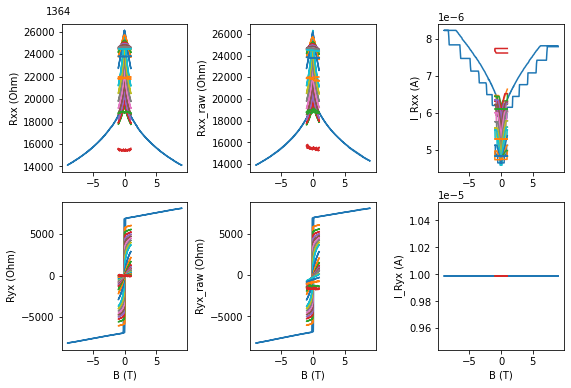

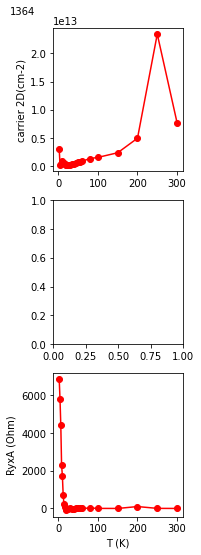

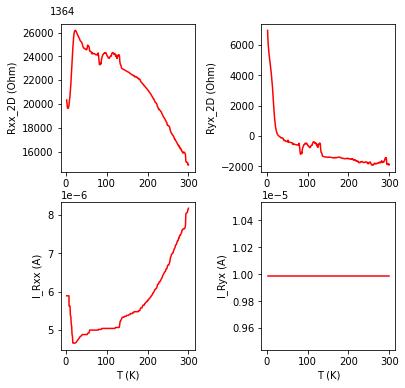

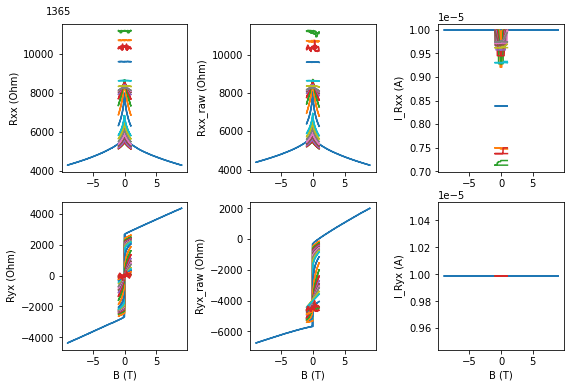

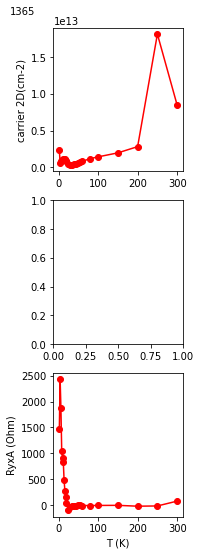

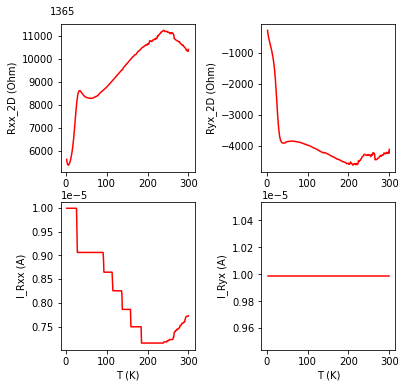

In [3]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
dirname = "231003_#1-1364_#1-1365"
pwd = f"/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/{dirname}"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
ch_num = [1, 2]
SAMPLE = "1364"
sample_str = SAMPLE
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)

ch_num = [3, 4]
SAMPLE = "1365"
sample_str = SAMPLE
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230525_#1-1354/1354_2


<ipython-input-8-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-8-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-8-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-8-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-8-aa38d93962cb>:219: FutureWarning: T

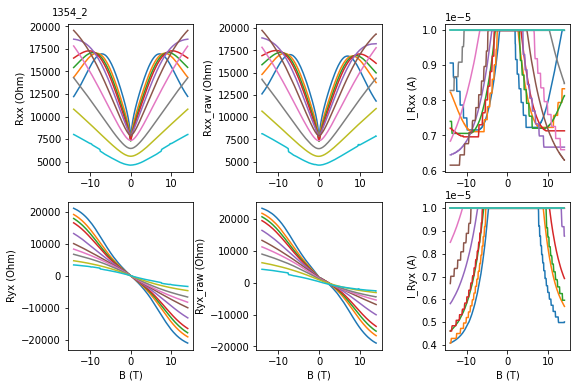

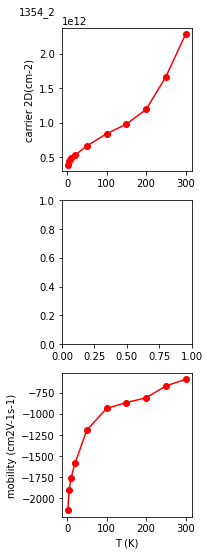

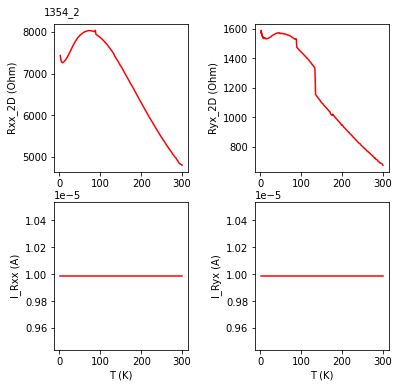

In [10]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1354_2"
dirname = "230525_#1-1354"
pwd = f"/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/{dirname}"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1360_2


<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: T

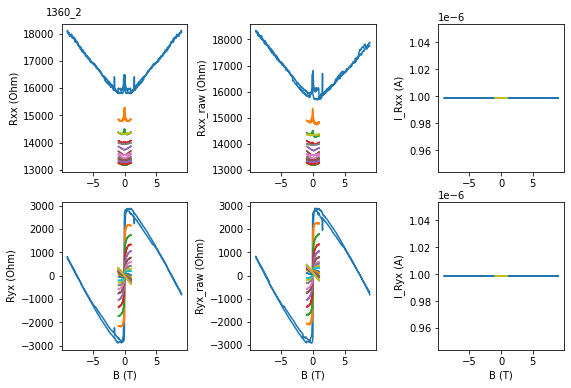

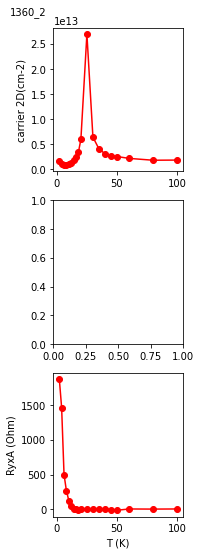

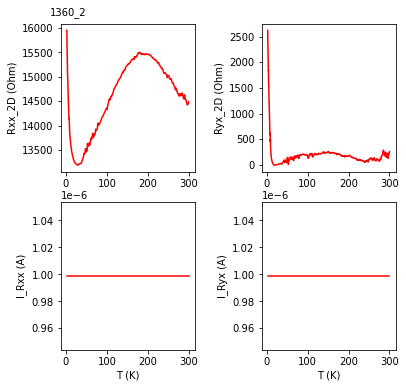

In [5]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1360_2"
dirname = "230719_#1-1359_#1-1360"
pwd = f"/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/{dirname}"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT2.dat")
ch_num = [3, 4]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


makedirs : /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1359_2
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1359_2


<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: T

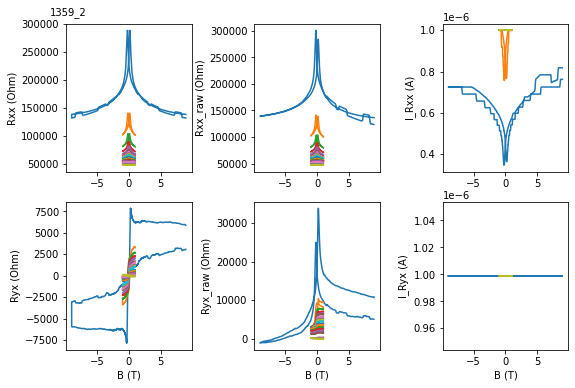

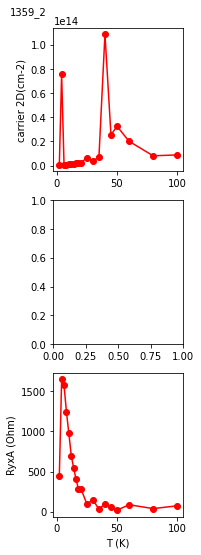

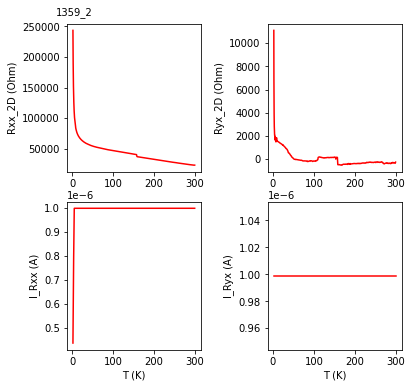

In [4]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1359_2"
dirname = "230719_#1-1359_#1-1360"
pwd = f"/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/{dirname}"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT2.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


/Users/uedataiga/Desktop/卒業研究/前期/notebook
makedirs : /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)/1357_
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)/1357_


<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-2-aa38d93962cb>:219: FutureWarning: T

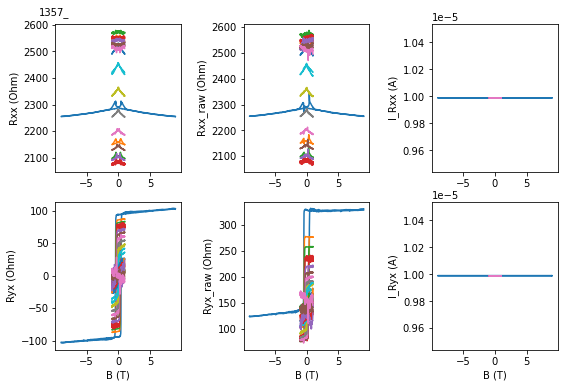

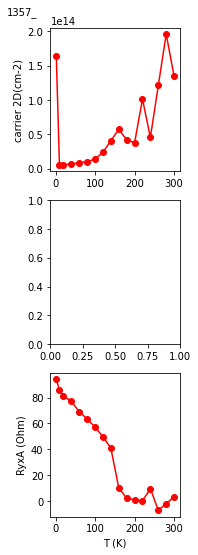

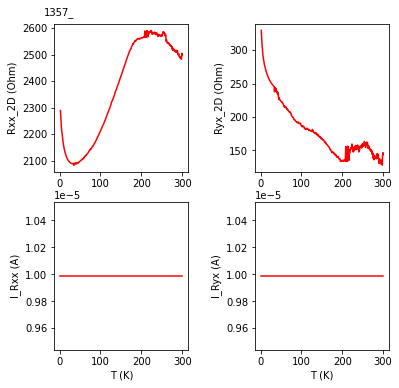

In [7]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1357_"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)"
filepath_Hall = os.path.join(pwd, r"Hall_allTemp.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


In [ ]:
# やってあった
# # import ppms, os
# # 全ての温度に対しても，2Kだけのデータに対してもできる？
# SAMPLE = "1354"
# pwd = os.getcwd()
# print(pwd)
# pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230525_#1-1354"
# filepath_Hall = os.path.join(pwd, r"Hall.dat")
# filepath_RT = os.path.join(pwd, r"RT.dat")
# ch_num = [1, 2]
# sample_str = SAMPLE
# thickness = 0  # 単位は[m]
# temp_threshold = 0.1

# # 実行
# analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
# analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


/Users/uedataiga/Desktop/卒業研究/前期/notebook
makedirs : /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230726_#1-1362/1362
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230726_#1-1362/1362


<ipython-input-27-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-27-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-27-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-27-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-27-aa38d93962cb>:219: FutureWarni

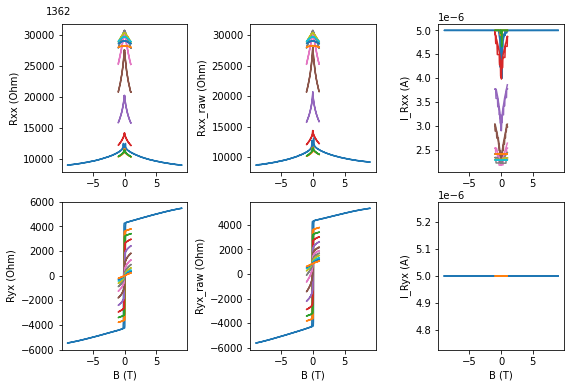

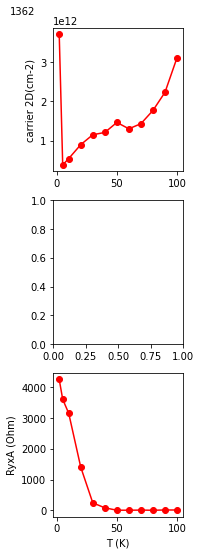

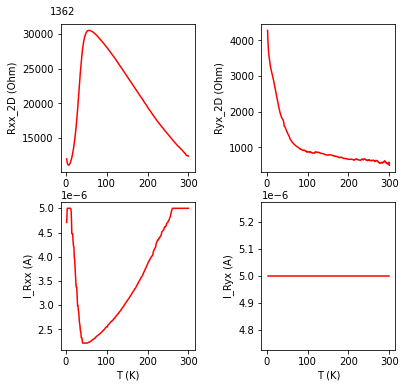

In [32]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1362"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230726_#1-1362"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


In [ ]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1354"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


/Users/uedataiga/Desktop/卒業研究/前期/notebook
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1359


<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarni

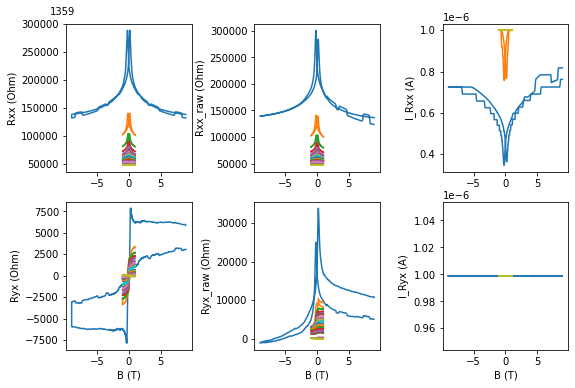

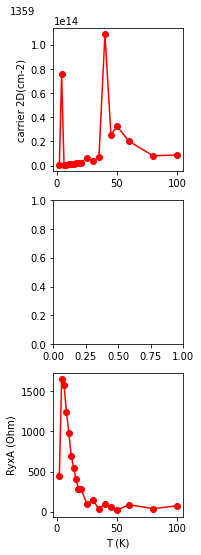

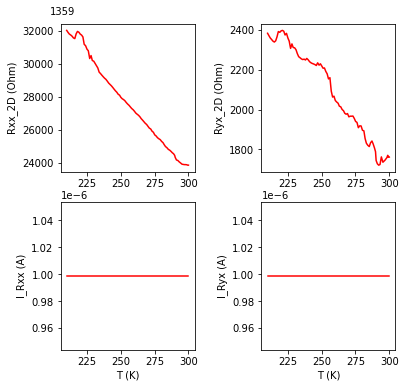

In [18]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1359"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


/Users/uedataiga/Desktop/卒業研究/前期/notebook
makedirs : /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1360
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360/1360


<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarni

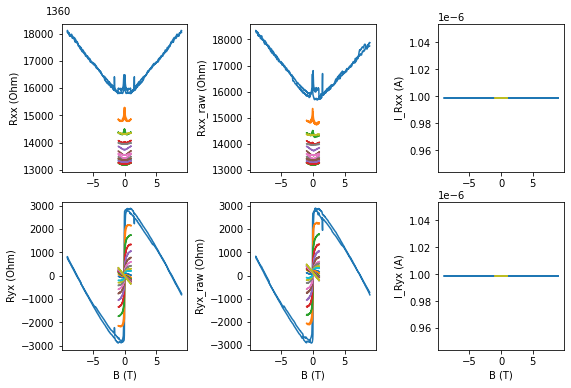

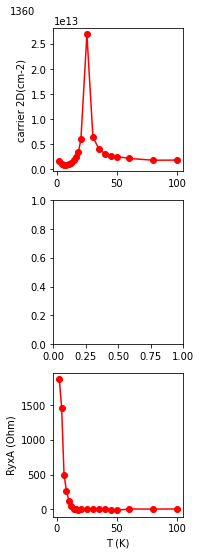

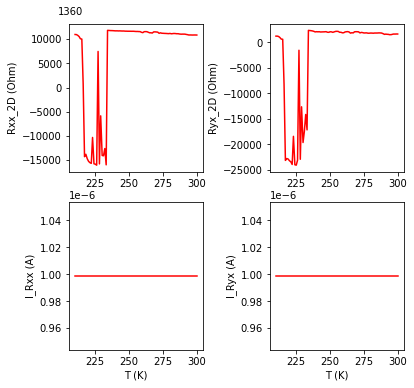

In [17]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1360"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230719_#1-1359_#1-1360"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [3, 4]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


/Users/uedataiga/Desktop/卒業研究/前期/notebook
savepath /Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230720_#1-1361_#2-1421/1361


<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_summary = df_summary.append(series_summary, ignore_index=True)
<ipython-input-15-aa38d93962cb>:219: FutureWarni

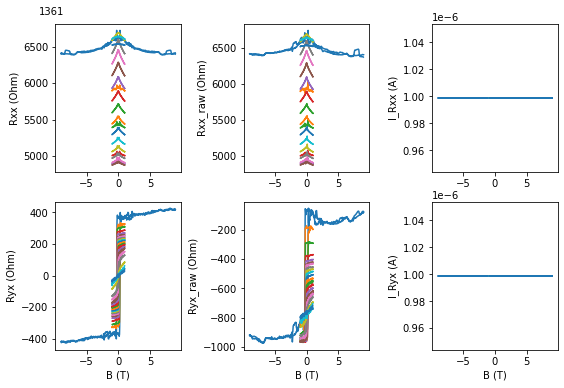

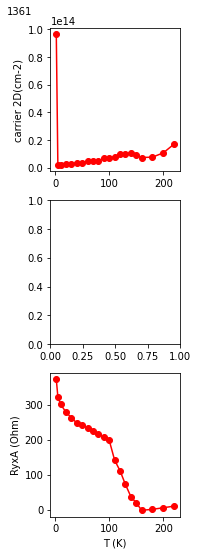

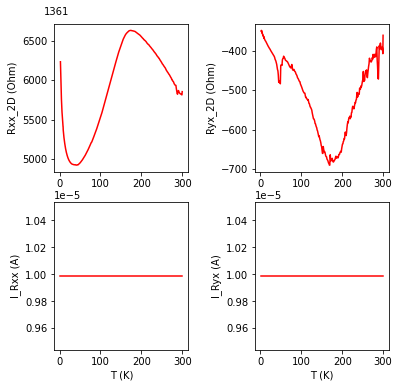

In [20]:
# import ppms, os
# 全ての温度に対しても，2Kだけのデータに対してもできる？
SAMPLE = "1361"
pwd = os.getcwd()
print(pwd)
pwd = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230720_#1-1361_#2-1421"
filepath_Hall = os.path.join(pwd, r"Hall.dat")
filepath_RT = os.path.join(pwd, r"RT.dat")
ch_num = [1, 2]
sample_str = SAMPLE
thickness = 0  # 単位は[m]
temp_threshold = 0.1

# 実行
analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


In [21]:
# # import os
# # import ppms
# # import sys
# # import sys
# # sys.path.append("../utils")
# # pwd = os.getcwd()

# filepath_Hall = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)/Hall_allTemp.dat"  # os.path.join(pwd, r"Hall_allTemp.dat")
# # filepath_RT = os.path.join(pwd, r"RT.dat")
# ch_num = [1, 2]
# sample_str = f"{SAMPLE}_allTemp"
# thickness = 0  # 単位は[m]
# temp_threshold = 0.1

# # 実行
# analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
# # ppms.analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


In [22]:
# import sys
# import sys
# sys.path.append("../utils")
# import ppms
# import os

# pwd = os.getcwd()
# filepath_Hall = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)/Hall_allTemp.dat" # os.path.join(pwd, r"Hall_allTemp.dat")
# # filepath_RT = os.path.join(pwd, r"RT.dat")
# ch_num = [1, 2]
# sample_str = "/Users/uedataiga/Desktop/卒業研究/前期/Data/PPMS/230628_#1-1357(CBST)/1357_allTemp"
# thickness = 0  # 単位は[m]
# temp_threshold = 0.1

# # 実行
# ppms.analyze_Hall_multi_temps_ppms(filepath_Hall, ch_num, sample_str, thickness, temp_threshold)
# # ppms.analyze_RT_ppms(filepath_RT, ch_num, sample_str, thickness)


In [23]:
# temp_dep: 色々な温度依存性
# carrier：物質によって異なる→物質によるので
# carrier2D: r_yxの傾きの高磁場（単位面積cm2あたり）
# cf) 3Dはcm3あたり
# HallAngle0: 0磁場における
# RyxA: 0Tにおける異常ホール効果
# RyxA_norm: の正規化
# temps: 温度つまりx軸

# Draw_hall: 非磁性体（上げて下げry必要ない）←BSTの時とか
# Draw_hall
磁性体においてmobilityを求めるのは難しい←2Kとか急に落ち込んでいたりする．あまり解析に使えない

In [24]:
# Arrott plot
# 後で調べる
# まだ使わない方が良い

In [25]:
# 各温度でのhallプロットだけ

In [26]:
# rho_yxとT
# モード: 俺せんとマーカー